# Betti Curve Plots 2.0

Plots betti curves up to H2 for *individual* dgms profiles

- Input: pickle file containing one dgms profile (np array(s) per homology group dimension)
- Output: smoothed Betti curve plot

Author: @emilyekstrum
<br> 11/17/25

In [ ]:
import pickle as pkl
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [ ]:
#utils

def gaussian_smooth(y, sigma=2.0):
    """ Apply Gaussian smoothing to a 1D array.
    Args:
        y (np.ndarray): 1D array to be smoothed.
        sigma (float): Standard deviation for Gaussian kernel.
    Returns:
        np.ndarray: Smoothed 1D array."""
    
    if sigma <= 0:
        return y
    try:
        return gaussian_filter1d(y, sigma=sigma, mode="nearest")
    except Exception:
        radius = int(max(1, round(3 * sigma)))
        xs = np.arange(-radius, radius + 1, dtype=float)
        kernel = np.exp(-0.5 * (xs / sigma) ** 2)
        kernel /= kernel.sum()
        return np.convolve(y, kernel, mode="same")


def safe_min(arr):
    """ finds the minimum of an array ignoring non-finite values.
    Args:
        arr (np.ndarray): Input array.
    Returns:
        float: Minimum value or 0.0 if no finite values exist."""
    
    arr = arr[np.isfinite(arr)]
    return np.min(arr) if arr.size else 0.0


def safe_max(arr):
    """ finds the maximum of an array ignoring non-finite values.
    Args:
        arr (np.ndarray): Input array.
    Returns:
        float: Maximum value or 1.0 if no finite values exist."""
    
    arr = arr[np.isfinite(arr)]
    return np.max(arr) if arr.size else 1.0


def normalize_grid(dgms, n_bins=600):
    """ Normalize the grid for persistence diagrams.
    Args:
        dgms (list of np.ndarray): List of persistence diagrams.
        n_bins (int): Number of bins for the grid.
    Returns:
        tuple: (s_grid, t_grid, t_min, t_max)
            normalized_grid (np.ndarray): Normalized grid in [0, 1].
            original_grid (np.ndarray): Original scale grid.
            t_min (float): Minimum birth time.
            t_max (float): Maximum death time."""
    
    births, deaths = [], []
    for dgm in dgms:
        if dgm is not None and len(dgm) > 0:
            births.append(dgm[:, 0])
            deaths.append(dgm[:, 1])

    births = np.concatenate(births) if births else np.array([0.0])
    deaths_all = np.concatenate(deaths) if deaths else np.array([1.0])

    t_min = safe_min(births)
    t_max = safe_max(deaths_all)
    if not np.isfinite(t_max):
        t_max = t_min + 1.0

    normalized_grid = np.linspace(0.0, 1.0, n_bins)
    original_grid = t_min + normalized_grid * (t_max - t_min)
    return normalized_grid, original_grid, t_min, t_max


def betti_curve_for_dim(dgm, original_grid):
    """ Compute the Betti curve for a dgms homology group rank
    Args:
        dgm (np.ndarray): Persistence diagram for a specific group rank.
        original_grid (np.ndarray): Grid of filtration values.
    Returns:
        np.ndarray: Betti curve values for to original_grid."""
    
    if dgm is None or len(dgm) == 0:
        return np.zeros_like(original_grid)
    births, deaths = dgm[:, 0], dgm[:, 1]
    alive = (births[:, None] <= original_grid[None, :]) & (
        np.isinf(deaths[:, None]) | (deaths[:, None] > original_grid[None, :])
    )
    return alive.sum(axis=0)


def load_dgms(pkl_path):
    """ Load persistence diagrams from a pickle file.
    Args:
        pkl_path (Path): Path to the pickle file.
    Returns:
        list of np.ndarray: List containing H0, H1, H2 persistence diagrams."""
    
    with open(pkl_path, "rb") as f:
        obj = pkl.load(f)
    if isinstance(obj, (list, tuple)) and len(obj) >= 3:
        return [np.asarray(obj[0]), np.asarray(obj[1]), np.asarray(obj[2])]
    if isinstance(obj, dict):
        if "dgms" in obj:
            dgms = obj["dgms"]
            if isinstance(dgms, (list, tuple)) and len(dgms) >= 3:
                return [np.asarray(dgms[0]), np.asarray(dgms[1]), np.asarray(dgms[2])]
        found = []
        for k in (0, 1, 2):
            if k in obj:
                found.append(np.asarray(obj[k]))
        if len(found) == 3:
            return found
    raise ValueError("Pickle must contain (H0, H1, H2) arrays or dict with keys 0,1,2 or 'dgms'.")


def plot_betti_curves(pickle_path, bins=600, sigma=2.0, title="Smoothed Betti Curves"):
    """ Plot smoothed Betti curves from persistence diagrams.
    Args:
        pickle_path (str): Path to the pickle file containing persistence diagrams.
        bins (int): Number of bins for the grid.
        sigma (float): Standard deviation for Gaussian smoothing.
        title (str): Title of the plot."""
    
    title = title
    dgms = load_dgms(Path(pickle_path))
    normalized_grid, original_grid, t_min, t_max = normalize_grid(dgms, n_bins=bins)

    x_grid = normalized_grid 

    labels = ["H0", "H1", "H2"]
    plt.figure(figsize=(8, 5))

    for label, dgm in zip(labels, dgms):
        try:
            if hasattr(dgm, "shape") and dgm.ndim == 1 and dgm.shape[0] == x_grid.shape[0]:
                y = dgm
            else:
                y = betti_curve_for_dim(dgm, original_grid)
        except Exception:
            y = betti_curve_for_dim(dgm, original_grid)

        y_smooth = gaussian_smooth(y, sigma=sigma)
        plt.plot(x_grid, y_smooth, linewidth=2, label=label)

    plt.xlabel("ε (Filtration diameter)")
    plt.ylabel("Betti numbers (Number of holes/cycles)")
    #plt.ylim(0, 10)
    plt.xlim(0, 0.1)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Examples

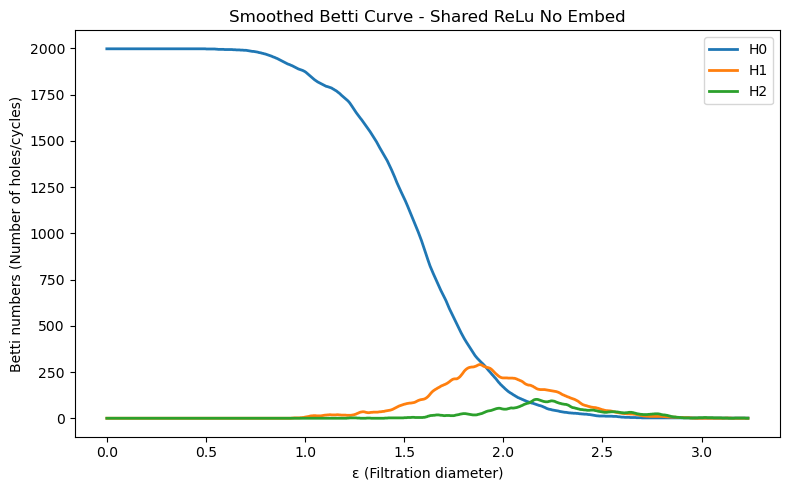

In [ ]:
# Example usage
plot_betti_curves(
    pickle_path=r"C:\Users\denmanlab\Desktop\Emily_rotation\nick_CNN_data\raw_dgms_no_embed.pkl", #change to path of single dgms pickle file
    bins=600,
    sigma=2.0,
    title="Smoothed Betti Curve - Shared ReLu No Embed",
)


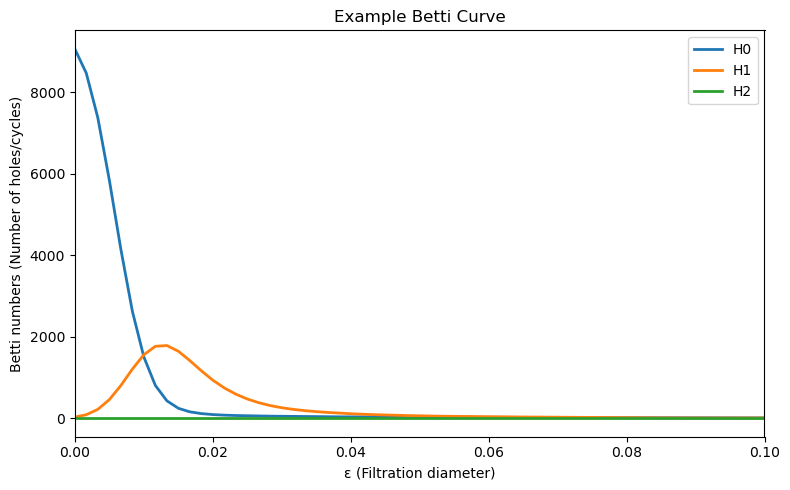

In [ ]:
plot_betti_curves(
    pickle_path=r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\PE_groups\3d\LGN\CEBRA_3d_LGN_dg_C159.pkl", #change to path of single dgms pickle file
    bins=600,
    sigma=2.0,
    title="Example Betti Curve",
)